In [2]:
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr
from skfolio.datasets import load_sp500_dataset, load_sp500_implied_vol_dataset
from skfolio.preprocessing import prices_to_returns

In [3]:
# data for mu

ticker = "AAPL"
start_date = "2001-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

adj_close_data = data["Adj Close"]

# Calculate returns
returns = adj_close_data.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


### Compute historical mean estimator: mu

$$
\hat{\mu}_N := \frac{1}{N} \sum_{k=0}^{N-1} \frac{1}{t_{k+1} - t_k} \left( \frac{S^M_{t_{k+1}} - S^M_{t_k}}{S^M_{t_k}} \right),
\tag{9}
$$


In [4]:
def compute_mu(prices):
    """
    Compute the mu estimator (mean of daily returns) from a sequence of prices.
    
    Parameters:
        prices (array-like): 1D array or list of prices.
        
    Returns:
        float: The computed mu value.
    """
    S = np.array(prices)
    t = np.arange(len(S))  # daily time steps (assume dt=1)
    N = len(S)
    
    mu_s = []
    for k in range(N - 1):
        mu_s.append((1 / (t[k+1] - t[k])) * ((S[k+1] - S[k]) / S[k])) # equation 9

    mu = np.sum(mu_s) / N
    
    return mu

### Compute volatility estimator: sigma

$$
\hat{\sigma}_N^2 := \frac{1}{N - 1} \sum_{k=0}^{N-1} \frac{1}{t_{k+1} - t_k} \left( \frac{S_{t_{k+1}} - S_{t_k}}{S_{t_k}} - (t_{k+1} - t_k) \hat{\mu}_N \right)^2,
\tag{14}
$$


In [5]:
def compute_sigma(prices):
    """
    Compute the sigma estimator (volatility) from a sequence of prices, using the previously computed mu.
    
    Parameters:
        prices (array-like): 1D array or list of prices.
        
    Returns:
        float: The computed sigma (volatility) value.
    """
    S = np.array(prices)
    t = np.arange(len(S))
    N = len(S)
    
    mu = compute_mu(prices)
    
    sigma_s = []
    for k in range(N - 1):
        sigma_s.append((( (S[k+1] - S[k]) / S[k] - (t[k+1] - t[k]) * mu )**2) / (t[k+1] - t[k])) # equation 14
    
    sigma_hat_sq = np.sum(sigma_s) / (N - 1)
    sigma = np.sqrt(sigma_hat_sq)
    
    return sigma

### Compute Parkinson volatility estimator: sigma

$$
\sigma_{\text{Parkinson}} = \sqrt{ \frac{1}{4 \ln 2} \cdot \frac{1}{T} \sum_{t=1}^{T} \left[ \ln\left( \frac{h_t}{l_t} \right) \right]^2 }
$$

where T is the number of days in the sample, $h_t$ is the high price, and $l_t$ is the low price on day t.

In [6]:
def compute_parkinson_sigma(high, low):
    T = len(high)

    return np.sqrt((1 / (4 * np.log(2))) * np.sum(np.log(high / low)**2, axis=0) / T) # equation 2

### Compute a rolling window estimator using a 30-day window. Plot results for all estimators.

In [7]:
df = returns.copy()

adj_close_data = data["Adj Close"]
high = data["High"]
low = data["Low"]

df = df.reindex(adj_close_data.index)

df["Adj Close"] = adj_close_data.values.squeeze()
df["High"] = high.values.squeeze()
df["Low"] = low.values.squeeze()

window_size = 30

Overall mu: 0.0013575872605764519


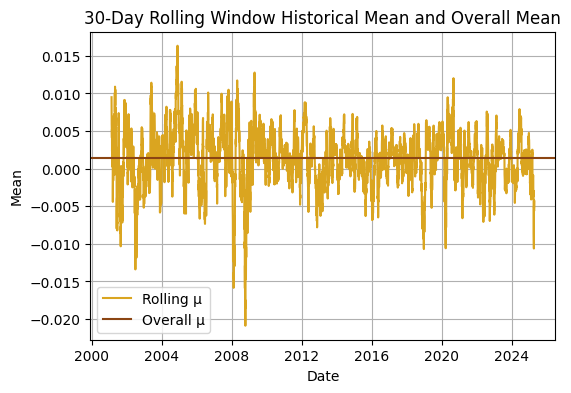

In [8]:
overall_mu = compute_mu(adj_close_data.values)
print(f"Overall mu: {overall_mu}")

rolling_mu = adj_close_data.rolling(window=window_size).apply(compute_mu, raw=True)

path = "figures/rolling_mu_overall"

plt.figure(figsize=(6, 4))
plt.plot(rolling_mu.index, rolling_mu, color='goldenrod', label='Rolling μ')
plt.axhline(y=overall_mu, color='saddlebrown', label='Overall μ')
plt.xlabel('Date')
plt.ylabel('Mean')
plt.title('30-Day Rolling Window Historical Mean and Overall Mean')
plt.legend()
plt.grid(True)
plt.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

Overall sigma: 0.022347948569082766
Overall sigma parkinson: Ticker
AAPL    0.018877
dtype: float64


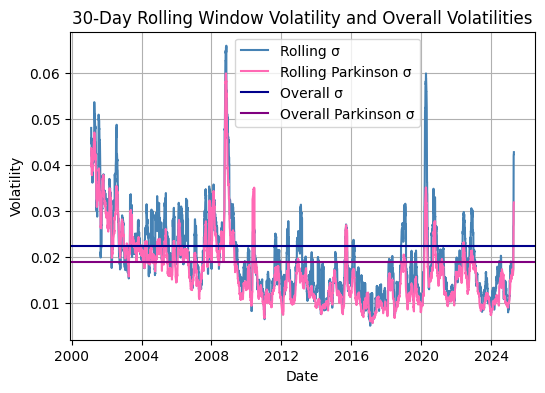

In [9]:
# historical volatility
overall_sigma = compute_sigma(adj_close_data.values)
print(f"Overall sigma: {overall_sigma}")

rolling_sigma = adj_close_data.rolling(window=window_size).apply(compute_sigma, raw=True)

# parkinson volatility
overall_sigma_parkinson = compute_parkinson_sigma(high, low)
print(f"Overall sigma parkinson: {overall_sigma_parkinson}")

rolling_sigma_parkinson = np.sqrt(
    (np.log(df["High"] / df["Low"])**2)
    .rolling(window=window_size)
    .sum() / window_size / (4 * np.log(2))
)

path = "figures/rolling_sigmas"

plt.figure(figsize=(6, 4))
plt.plot(rolling_sigma.index, rolling_sigma, color='steelblue', label='Rolling σ')
plt.plot(rolling_sigma_parkinson.index, rolling_sigma_parkinson, color='hotpink', label="Rolling Parkinson σ")
plt.axhline(y=overall_sigma, color='darkblue', label='Overall σ')
plt.axhline(y=overall_sigma_parkinson.item(), color='purple', label='Overall Parkinson σ')
plt.xlabel('Date')
plt.ylabel('Volatility') # or sigma
plt.title('30-Day Rolling Window Volatility and Overall Volatilities')
plt.legend()
plt.grid(True)
plt.legend(bbox_to_anchor=[0.34,1])
plt.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

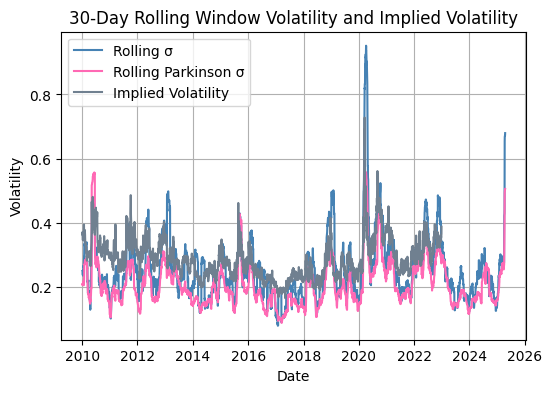

In [10]:
implied_vol = load_sp500_implied_vol_dataset()

# Filter all volatility series from 2010 onward
rolling_sigma = rolling_sigma.loc["2010":]
rolling_sigma_parkinson = rolling_sigma_parkinson.loc["2010":]
implied_vol = implied_vol.loc["2010":]

# add plot implied_volatility against Sigma and Sigma Parkinson
path = "figures/implied_vol_sigmas"
plt.figure(figsize=(6, 4))
plt.plot(rolling_sigma.index, rolling_sigma*np.sqrt(252), color='steelblue', label='Rolling σ')
plt.plot(rolling_sigma_parkinson.index, rolling_sigma_parkinson*np.sqrt(252), color='hotpink', label="Rolling Parkinson σ")
plt.plot(implied_vol.index, implied_vol.iloc[:,0], color='slategray', label="Implied Volatility")
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('30-Day Rolling Window Volatility and Implied Volatility')
plt.legend()
plt.grid(True)
plt.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

### Step 4: Implied Volatility Data and VIX Estimation

### Compute the estimated VIX using the etsimator VIX_t and compare it with the CBOE-quoted VIX

### The VIX squared is given by:

$$
\text{VIX}_t^2 = \frac{2e^{r\tau}}{\tau} \left(
\sum_{i=1}^{n_p - 1} P(t, t+\tau, K_i^{(p)}) \left( \frac{1}{K_i^{(p)}} - \frac{1}{K_{i+1}^{(p)}} \right)
+ \sum_{i=1}^{n_c} C(t, t+\tau, K_i^{(c)}) \left( \frac{1}{K_{i-1}^{(c)}} - \frac{1}{K_i^{(c)}} \right)
\right)
$$


In [11]:
def compute_vix(K_p, P_vals, K_c, C_vals, tau, r):
    sum_put = 0
    for i in range(1, len(K_p) - 1):
        sum_put += P_vals[i] * ((1 / K_p[i]) - (1 / K_p[i + 1]))

    sum_call = 0
    for i in range(1, len(K_c)):
        sum_call += C_vals[i] * ((1 / K_c[i - 1]) - (1 / K_c[i]))

    vix_squared = (2 * np.exp(r * tau) / tau) * (sum_put + sum_call)
    return vix_squared

### Compute forward price

$$
F_{t, t+\tau} := \mathbb{E}^{\mathbb{Q}}[S_{t+\tau} \mid \mathcal{F}_t] = e^{r \tau} S_t
$$


In [12]:
def compute_forward_price(stock_price, r, tau):
    return stock_price * np.exp(r * tau)

In [13]:
# get SPX data
spx_symbol = "^SPX"
today = "2025-03-05" # Keep this fixed in your implementation
end_date = today
start_date = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=365)
spx_data = yf.download(spx_symbol, start=start_date.strftime("%Y-%m-%d"), end=end_date)
lastBusDay = spx_data.index[-1]

# get last VIX of VIX data
vix_data = yf.download("^VIX", start=lastBusDay.strftime("%Y-%m-%d"),
                       end=(lastBusDay + datetime.timedelta(days=1)).strftime("%Y-%m-%d"))

actual_vix = vix_data["Close"].iloc[0].item()

# print CBOE VIX volatility
print(f"CBOE VIX: {actual_vix}\n")

stock_price = float(spx_data["Close"].iloc[-1].item())

# use data for VIX estimation
calls_df = pd.read_csv("Call_option_data_2025-04-03_final.csv")
puts_df = pd.read_csv("Put_option_data_2025-04-03_final.csv")

# parameters
tau = 30 / 365
r = 0.02

# compute forward price
forward_price = compute_forward_price(stock_price, tau, r)

# filter for out-of-the-money -> equation 22
puts_df = puts_df[puts_df["strike"] < forward_price] # puts smaller than forward price
calls_df = calls_df[calls_df["strike"] > forward_price] # calls greater than forward price 

# get put, call, and strike data from data files
K_p = puts_df["strike"].values
K_c = calls_df["strike"].values
# C_vals = (calls_df["ask"].values + calls_df["bid"].values) / 2
# P_vals = (puts_df["ask"].values + puts_df["bid"].values) / 2
C_vals = calls_df["Last"].values
P_vals = puts_df["Last"].values
# last change (otherwise refer to manual CBOE)

# compute VIX: compute the root*100 to get percentage
vix_squared = compute_vix(K_p, P_vals, K_c, C_vals, tau, r)
vix_estimate = np.sqrt(vix_squared) * 100

# print estimated VIX
print(f"Estimated VIX: {vix_estimate}\n")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True
CBOE VIX: 23.510000228881836

Estimated VIX: 20.342679518914633



[*********************100%***********************]  1 of 1 completed


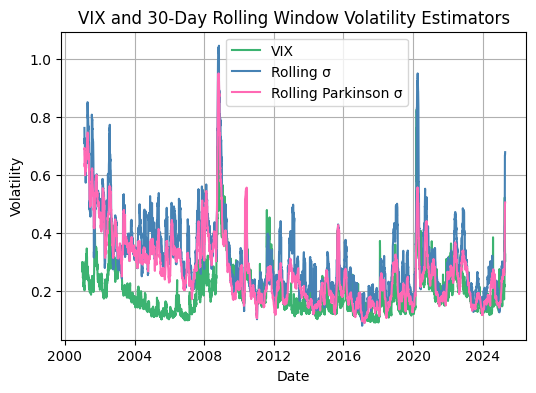

In [14]:
# compute rolling sigma using compute_sigma function and window for 30 days
rolling_sigma = adj_close_data.rolling(window=window_size).apply(compute_sigma, raw=True)

# compute rolling sigma for parkinson
rolling_sigma_parkinson = np.sqrt(
    (np.log(df["High"] / df["Low"])**2)
    .rolling(window=window_size)
    .sum() / window_size / (4 * np.log(2))
)

# change type
rolling_sigma_series = rolling_sigma.squeeze()
rolling_sigma_parkinson_series = rolling_sigma_parkinson.squeeze()

# annualize it (approx 252 trading days in year)
annualized_sigma = rolling_sigma_series * np.sqrt(252)
annualized_parkinson_sigma = rolling_sigma_parkinson_series * np.sqrt(252)

# starting date is 01-01-2001
start_date = "2001-01-01"

# end date is today
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

# download VIX data
vix_data = yf.download("^VIX", start=start_date, end=end_date)

# annualize it by /100
annualized_vix = vix_data["Close"] / 100

# path to save figure
path = "figures/volatility_over_years"

# plot
plt.figure(figsize=(6, 4))
plt.plot(vix_data.index, annualized_vix, label="VIX", color='mediumseagreen')
plt.plot(rolling_sigma.index, annualized_sigma, color='steelblue', label='Rolling σ')
plt.plot(rolling_sigma_parkinson.index, annualized_parkinson_sigma, color='hotpink', label="Rolling Parkinson σ")
plt.plot()
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title("VIX and 30-Day Rolling Window Volatility Estimators")
plt.legend(bbox_to_anchor=[0.34,1])
plt.grid(True)
plt.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

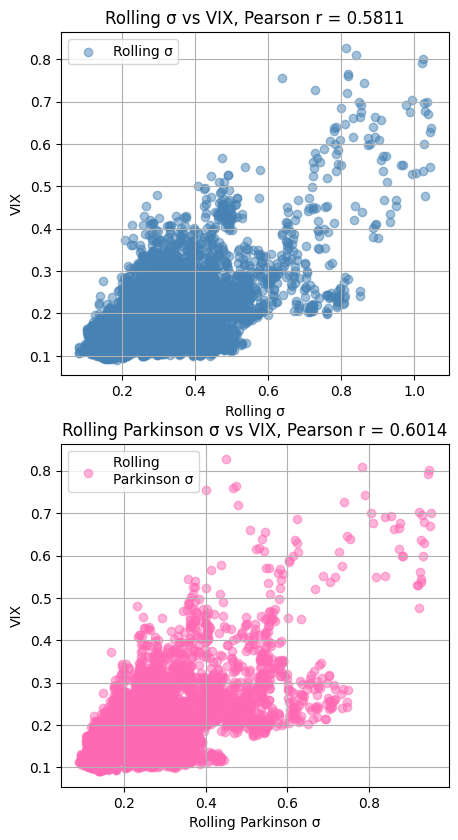

In [15]:
# for correlation tests, put all data in a dataframe
data = pd.concat([annualized_sigma, annualized_parkinson_sigma, annualized_vix], axis=1)
data.columns = ["rolling_sigma", "rolling_sigma_parkinson", "VIX"]
data = data.dropna()

# Perform Pearson correlation tests
corr_sigma, p_val_sigma = pearsonr(data["rolling_sigma"], data["VIX"])
corr_parkinson, p_val_parkinson = pearsonr(data["rolling_sigma_parkinson"], data["VIX"])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 9.8))
path = "figures/correlation_volatilities"

# plot 1: Scatter plot for Rolling σ vs VIX
ax1.grid(True)
ax1.scatter(data["rolling_sigma"], data["VIX"], color='steelblue', alpha=0.5, label='Rolling σ')
ax1.set_ylabel("VIX")
ax1.set_xlabel("Rolling σ")
ax1.set_title(f"Rolling σ vs VIX, Pearson r = {corr_sigma:.4f}")
ax1.legend()

# plot 2: Scatter plot for Rolling Parkinson σ vs VIX
ax2.grid(True)
ax2.scatter(data["rolling_sigma_parkinson"], data["VIX"], color='hotpink', alpha=0.5,  label='Rolling \nParkinson σ')
ax2.set_xlabel("Rolling Parkinson σ")
ax2.set_ylabel("VIX")
ax2.set_title(f"Rolling Parkinson σ vs VIX, Pearson r = {corr_parkinson:.4f}")
ax2.legend()
plt.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     33.16
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           2.51e-08
Time:                        18:08:09   Log-Likelihood:                 856.94
No. Observations:                 249   AIC:                            -1710.
Df Residuals:                     247   BIC:                            -1703.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0141      0.002      5.852      0.0

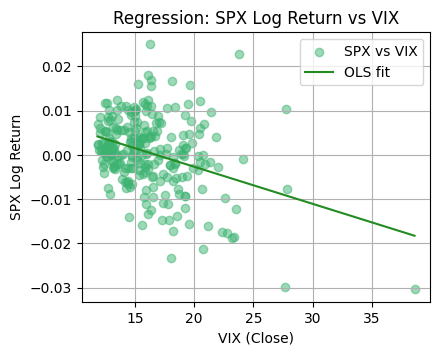

In [16]:
# get from SPX data the Close data
spx_data["log_return"] = np.log(spx_data["Close"] / spx_data["Close"].shift(1))
spx_data = spx_data.dropna()

# get from VIX data the Close data
vix_close = vix_data["Close"]["^VIX"]
vix_close = vix_close.dropna().rename("VIX")

# merge SPX log returns and VIX
spx_data.columns = spx_data.columns.get_level_values(0)
data = spx_data[["log_return"]].join(vix_close, how="inner")

# time series regression
X = sm.add_constant(data["VIX"])  # Add intercept
y = data["log_return"]

# fit model and prepare data for plot
model = sm.OLS(y, X).fit() # ordinary least squares regression
vix_sorted = np.sort(data["VIX"])
y_pred = model.predict(sm.add_constant(vix_sorted))
print(model.summary())

path = "figures/regression_SPX_VIX"

# plot scatter with regression line
plt.figure(figsize=(4.5, 3.5))
plt.scatter(data["VIX"], data["log_return"], alpha=0.5, color="mediumseagreen", label="SPX vs VIX")
plt.plot(vix_sorted, y_pred, color="forestgreen", label="OLS fit")
plt.xlabel("VIX (Close)")
plt.ylabel("SPX Log Return")
plt.title("Regression: SPX Log Return vs VIX")
plt.grid(True)
plt.legend()
plt.savefig(path, dpi=300, bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                  0.005957
Date:                Thu, 17 Apr 2025   Prob (F-statistic):              0.939
Time:                        18:08:13   Log-Likelihood:                 841.26
No. Observations:                 249   AIC:                            -1679.
Df Residuals:                     247   BIC:                            -1671.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.003      0.277

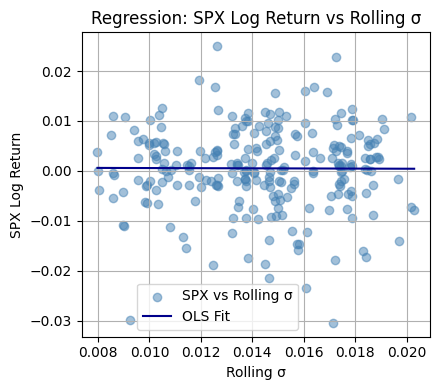

In [17]:
# compute rolling sigma using compute_sigma function and window for 30 days
rolling_sigma = adj_close_data.rolling(window=window_size).apply(compute_sigma, raw=True)
df_sigma = spx_data[["log_return"]].join(rolling_sigma.iloc[:, 0].rename("rolling_sigma")).dropna()

# Regression: SPX log return vs Rolling σ
X = sm.add_constant(df_sigma["rolling_sigma"])
y = df_sigma["log_return"]
model = sm.OLS(y, X).fit()
x_sorted = np.sort(df_sigma["rolling_sigma"])
y_pred = model.predict(sm.add_constant(x_sorted))
print(model.summary())

# plotting
plt.figure(figsize=(4.5,4))
plt.scatter(df_sigma["rolling_sigma"], df_sigma["log_return"],
            alpha=0.5, color="steelblue", label="SPX vs Rolling σ")
plt.plot(x_sorted, y_pred, color="darkblue", label="OLS Fit")
plt.xlabel("Rolling σ")
plt.ylabel("SPX Log Return")
plt.title("Regression: SPX Log Return vs Rolling σ")
plt.grid(True)
plt.legend(loc='lower center', bbox_to_anchor=(0.39, 0.0001), ncol=1, frameon=True)
plt.tight_layout()
plt.savefig("figures/spx_vs_sigmas.png", dpi=300, bbox_inches='tight')
plt.show()